# Deep Neural Network for Image Classification: Application

When you finish this, you will have finished the last programming assignment of Week 4, and also the last programming assignment of this course! 

You will use use the functions you'd implemented in the previous assignment to build a deep network, and apply it to cat vs non-cat classification. Hopefully, you will see an improvement in accuracy relative to your previous logistic regression implementation.  

**After this assignment you will be able to:**
- Build and apply a deep neural network to supervised learning. 

Let's get started!

## 1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- dnn_app_utils provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [18]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2 - Dataset

You will use the same "Cat vs non-Cat" dataset as in "Logistic Regression as a Neural Network" (Assignment 2). The model you had built had 70% test accuracy on classifying cats vs non-cats images. Hopefully, your new model will perform a better!

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labelled as cat (1) or non-cat (0)
    - a test set of m_test images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [3]:
tt = np.arange(18).reshape(2,3,3)
tt[:]

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]]])

In [4]:
train_x_orig.shape,train_y.shape,test_x_orig.shape, test_y.shape

((209, 64, 64, 3), (1, 209), (50, 64, 64, 3), (1, 50))

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a non-cat picture.


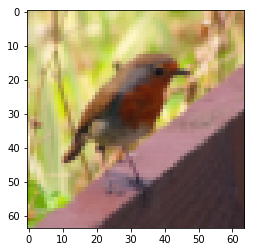

In [5]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [4]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [27]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ equals $64 \times 64 \times 3$ which is the size of one reshaped image vector.

## 4 - Two-layer neural network

**Question**:  Use the helper functions you have implemented in the previous assignment to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [6]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid")
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2, Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Run the cell below to train your parameters. See if your model runs. The cost should be decreasing. It may take up to 5 minutes to run 2500 iterations. Check if the "Cost after iteration 0" matches the expected output below, if not click on the square (⬛) on the upper bar of the notebook to stop the cell and try to find your error.

Cost after iteration 0: 0.6930497356599888
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.47549013139433255
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.4007977536203886
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196264
Cost after iteration 1200: 0.2749137728213015
Cost after iteration 1300: 0.24681768210614846
Cost after iteration 1400: 0.19850735037466108
Cost after iteration 1500: 0.17448318112556654
Cost after iteration 1600: 0.17080762978096023
Cost after iteration 1700: 0.11306524562164728
Cost after iteration 1800: 0.09629426845937154
Cost after iteration 1900: 0.08342617959726861
Cost after iteration 2000: 0.07439078704319084
Cost after iteration 2100: 0.0663074

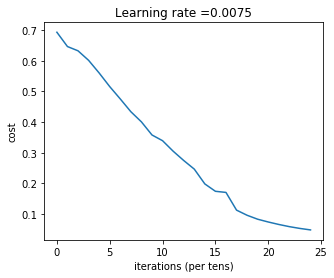

In [10]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

**Expected Output**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.048554785628770206 </td>
    </tr>
</table>

Good thing you built a vectorized implementation! Otherwise it might have taken 10 times longer to train this.

Now, you can use the trained parameters to classify images from the dataset. To see your predictions on the training and test sets, run the cell below.

In [11]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 1.0


**Expected Output**:
<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 1.0 </td>
    </tr>
</table>

In [12]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


**Expected Output**:

<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 0.72 </td>
    </tr>
</table>

**Note**: You may notice that running the model on fewer iterations (say 1500) gives better accuracy on the test set. This is called "early stopping" and we will talk about it in the next course. Early stopping is a way to prevent overfitting. 

Congratulations! It seems that your 2-layer neural network has better performance (72%) than the logistic regression implementation (70%, assignment week 2). Let's see if you can do even better with an $L$-layer model.

## 5 - L-layer Neural Network

**Question**: Use the helper functions you have implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [24]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [30]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [34]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 16, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    """
    L-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    
    # Initialize parameters
    parameters = initialize_parameters_deep(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            aL, caches = L_model_forward(minibatch_X, parameters)
            print(aL.shape)
            # Compute cost
            cost = compute_cost(aL, minibatch_Y)

            # Backward propagation
            grads = L_model_backward(aL, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                print(t)
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

You will now train the model as a 4-layer neural network. 

Run the cell below to train your model. The cost should decrease on every iteration. It may take up to 5 minutes to run 2500 iterations. Check if the "Cost after iteration 0" matches the expected output below, if not click on the square (⬛) on the upper bar of the notebook to stop the cell and try to find your error.

In [22]:
# GRADED FUNCTION: random_mini_batches
import math
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size:(k+1)*mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, (k+1)*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, (k+1)*mini_batch_size:]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


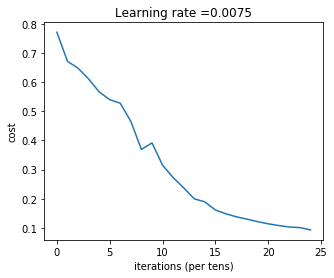

In [31]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [ ]:
parameters = model(train_x, train_y, layers_dims, optimizer="adam", num_epochs = 2500, print_cost = True)

(1, 16)
1
(1, 16)
2
(1, 16)
3
(1, 16)
4
(1, 16)
5
(1, 16)
6
(1, 16)
7
(1, 16)
8
(1, 16)
9
(1, 16)
10
(1, 16)
11
(1, 16)
12
(1, 16)
13
(1, 1)
14
Cost after epoch 0: 0.696436
(1, 16)
15
(1, 16)
16
(1, 16)
17
(1, 16)
18
(1, 16)
19
(1, 16)
20
(1, 16)
21
(1, 16)
22
(1, 16)
23
(1, 16)
24
(1, 16)
25
(1, 16)
26
(1, 16)
27
(1, 1)
28
(1, 16)
29
(1, 16)
30
(1, 16)
31
(1, 16)
32
(1, 16)
33
(1, 16)
34
(1, 16)
35
(1, 16)
36
(1, 16)
37
(1, 16)
38
(1, 16)
39
(1, 16)
40
(1, 16)
41
(1, 1)
42
(1, 16)
43
(1, 16)
44
(1, 16)
45
(1, 16)
46
(1, 16)
47
(1, 16)
48
(1, 16)
49
(1, 16)
50
(1, 16)
51
(1, 16)
52
(1, 16)
53
(1, 16)
54
(1, 16)
55
(1, 1)
56
(1, 16)
57
(1, 16)
58
(1, 16)
59
(1, 16)
60
(1, 16)
61
(1, 16)
62
(1, 16)
63
(1, 16)
64
(1, 16)
65
(1, 16)
66
(1, 16)
67
(1, 16)
68
(1, 16)
69
(1, 1)
70
(1, 16)
71
(1, 16)
72
(1, 16)
73
(1, 16)
74
(1, 16)
75
(1, 16)
76
(1, 16)
77
(1, 16)
78
(1, 16)
79
(1, 16)
80
(1, 16)
81
(1, 16)
82
(1, 16)
83
(1, 1)
84
(1, 16)
85
(1, 16)
86
(1, 16)
87
(1, 16)
88
(1, 16)
89
(1, 16)

(1, 16)
695
(1, 16)
696
(1, 16)
697
(1, 16)
698
(1, 16)
699
(1, 1)
700
(1, 16)
701
(1, 16)
702
(1, 16)
703
(1, 16)
704
(1, 16)
705
(1, 16)
706
(1, 16)
707
(1, 16)
708
(1, 16)
709
(1, 16)
710
(1, 16)
711
(1, 16)
712
(1, 16)
713
(1, 1)
714
(1, 16)
715
(1, 16)
716
(1, 16)
717
(1, 16)
718
(1, 16)
719
(1, 16)
720
(1, 16)
721
(1, 16)
722
(1, 16)
723
(1, 16)
724
(1, 16)
725
(1, 16)
726
(1, 16)
727
(1, 1)
728
(1, 16)
729
(1, 16)
730
(1, 16)
731
(1, 16)
732
(1, 16)
733
(1, 16)
734
(1, 16)
735
(1, 16)
736
(1, 16)
737
(1, 16)
738
(1, 16)
739
(1, 16)
740
(1, 16)
741
(1, 1)
742
(1, 16)
743
(1, 16)
744
(1, 16)
745
(1, 16)
746
(1, 16)
747
(1, 16)
748
(1, 16)
749
(1, 16)
750
(1, 16)
751
(1, 16)
752
(1, 16)
753
(1, 16)
754
(1, 16)
755
(1, 1)
756
(1, 16)
757
(1, 16)
758
(1, 16)
759
(1, 16)
760
(1, 16)
761
(1, 16)
762
(1, 16)
763
(1, 16)
764
(1, 16)
765
(1, 16)
766
(1, 16)
767
(1, 16)
768
(1, 16)
769
(1, 1)
770
(1, 16)
771
(1, 16)
772
(1, 16)
773
(1, 16)
774
(1, 16)
775
(1, 16)
776
(1, 16)
777
(1, 16)
77

(1, 16)
1356
(1, 16)
1357
(1, 1)
1358
(1, 16)
1359
(1, 16)
1360
(1, 16)
1361
(1, 16)
1362
(1, 16)
1363
(1, 16)
1364
(1, 16)
1365
(1, 16)
1366
(1, 16)
1367
(1, 16)
1368
(1, 16)
1369
(1, 16)
1370
(1, 16)
1371
(1, 1)
1372
(1, 16)
1373
(1, 16)
1374
(1, 16)
1375
(1, 16)
1376
(1, 16)
1377
(1, 16)
1378
(1, 16)
1379
(1, 16)
1380
(1, 16)
1381
(1, 16)
1382
(1, 16)
1383
(1, 16)
1384
(1, 16)
1385
(1, 1)
1386
(1, 16)
1387
(1, 16)
1388
(1, 16)
1389
(1, 16)
1390
(1, 16)
1391
(1, 16)
1392
(1, 16)
1393
(1, 16)
1394
(1, 16)
1395
(1, 16)
1396
(1, 16)
1397
(1, 16)
1398
(1, 16)
1399
(1, 1)
1400
(1, 16)
1401
(1, 16)
1402
(1, 16)
1403
(1, 16)
1404
(1, 16)
1405
(1, 16)
1406
(1, 16)
1407
(1, 16)
1408
(1, 16)
1409
(1, 16)
1410
(1, 16)
1411
(1, 16)
1412
(1, 16)
1413
(1, 1)
1414
(1, 16)
1415
(1, 16)
1416
(1, 16)
1417
(1, 16)
1418
(1, 16)
1419
(1, 16)
1420
(1, 16)
1421
(1, 16)
1422
(1, 16)
1423
(1, 16)
1424
(1, 16)
1425
(1, 16)
1426
(1, 16)
1427
(1, 1)
1428
(1, 16)
1429
(1, 16)
1430
(1, 16)
1431
(1, 16)
1432
(1, 1

1998
(1, 16)
1999
(1, 16)
2000
(1, 16)
2001
(1, 1)
2002
(1, 16)
2003
(1, 16)
2004
(1, 16)
2005
(1, 16)
2006
(1, 16)
2007
(1, 16)
2008
(1, 16)
2009
(1, 16)
2010
(1, 16)
2011
(1, 16)
2012
(1, 16)
2013
(1, 16)
2014
(1, 16)
2015
(1, 1)
2016
(1, 16)
2017
(1, 16)
2018
(1, 16)
2019
(1, 16)
2020
(1, 16)
2021
(1, 16)
2022
(1, 16)
2023
(1, 16)
2024
(1, 16)
2025
(1, 16)
2026
(1, 16)
2027
(1, 16)
2028
(1, 16)
2029
(1, 1)
2030
(1, 16)
2031
(1, 16)
2032
(1, 16)
2033
(1, 16)
2034
(1, 16)
2035
(1, 16)
2036
(1, 16)
2037
(1, 16)
2038
(1, 16)
2039
(1, 16)
2040
(1, 16)
2041
(1, 16)
2042
(1, 16)
2043
(1, 1)
2044
(1, 16)
2045
(1, 16)
2046
(1, 16)
2047
(1, 16)
2048
(1, 16)
2049
(1, 16)
2050
(1, 16)
2051
(1, 16)
2052
(1, 16)
2053
(1, 16)
2054
(1, 16)
2055
(1, 16)
2056
(1, 16)
2057
(1, 1)
2058
(1, 16)
2059
(1, 16)
2060
(1, 16)
2061
(1, 16)
2062
(1, 16)
2063
(1, 16)
2064
(1, 16)
2065
(1, 16)
2066
(1, 16)
2067
(1, 16)
2068
(1, 16)
2069
(1, 16)
2070
(1, 16)
2071
(1, 1)
2072
(1, 16)
2073
(1, 16)
2074
(1, 16)
2075


(1, 16)
2636
(1, 16)
2637
(1, 16)
2638
(1, 16)
2639
(1, 16)
2640
(1, 16)
2641
(1, 16)
2642
(1, 16)
2643
(1, 16)
2644
(1, 16)
2645
(1, 1)
2646
(1, 16)
2647
(1, 16)
2648
(1, 16)
2649
(1, 16)
2650
(1, 16)
2651
(1, 16)
2652
(1, 16)
2653
(1, 16)
2654
(1, 16)
2655
(1, 16)
2656
(1, 16)
2657
(1, 16)
2658
(1, 16)
2659
(1, 1)
2660
(1, 16)
2661
(1, 16)
2662
(1, 16)
2663
(1, 16)
2664
(1, 16)
2665
(1, 16)
2666
(1, 16)
2667
(1, 16)
2668
(1, 16)
2669
(1, 16)
2670
(1, 16)
2671
(1, 16)
2672
(1, 16)
2673
(1, 1)
2674
(1, 16)
2675
(1, 16)
2676
(1, 16)
2677
(1, 16)
2678
(1, 16)
2679
(1, 16)
2680
(1, 16)
2681
(1, 16)
2682
(1, 16)
2683
(1, 16)
2684
(1, 16)
2685
(1, 16)
2686
(1, 16)
2687
(1, 1)
2688
(1, 16)
2689
(1, 16)
2690
(1, 16)
2691
(1, 16)
2692
(1, 16)
2693
(1, 16)
2694
(1, 16)
2695
(1, 16)
2696
(1, 16)
2697
(1, 16)
2698
(1, 16)
2699
(1, 16)
2700
(1, 16)
2701
(1, 1)
2702
(1, 16)
2703
(1, 16)
2704
(1, 16)
2705
(1, 16)
2706
(1, 16)
2707
(1, 16)
2708
(1, 16)
2709
(1, 16)
2710
(1, 16)
2711
(1, 16)
2712
(1, 

(1, 16)
3279
(1, 16)
3280
(1, 16)
3281
(1, 16)
3282
(1, 16)
3283
(1, 16)
3284
(1, 16)
3285
(1, 16)
3286
(1, 16)
3287
(1, 16)
3288
(1, 16)
3289
(1, 1)
3290
(1, 16)
3291
(1, 16)
3292
(1, 16)
3293
(1, 16)
3294
(1, 16)
3295
(1, 16)
3296
(1, 16)
3297
(1, 16)
3298
(1, 16)
3299
(1, 16)
3300
(1, 16)
3301
(1, 16)
3302
(1, 16)
3303
(1, 1)
3304
(1, 16)
3305
(1, 16)
3306
(1, 16)
3307
(1, 16)
3308
(1, 16)
3309
(1, 16)
3310
(1, 16)
3311
(1, 16)
3312
(1, 16)
3313
(1, 16)
3314
(1, 16)
3315
(1, 16)
3316
(1, 16)
3317
(1, 1)
3318
(1, 16)
3319
(1, 16)
3320
(1, 16)
3321
(1, 16)
3322
(1, 16)
3323
(1, 16)
3324
(1, 16)
3325
(1, 16)
3326
(1, 16)
3327
(1, 16)
3328
(1, 16)
3329
(1, 16)
3330
(1, 16)
3331
(1, 1)
3332
(1, 16)
3333
(1, 16)
3334
(1, 16)
3335
(1, 16)
3336
(1, 16)
3337
(1, 16)
3338
(1, 16)
3339
(1, 16)
3340
(1, 16)
3341
(1, 16)
3342
(1, 16)
3343
(1, 16)
3344
(1, 16)
3345
(1, 1)
3346
(1, 16)
3347
(1, 16)
3348
(1, 16)
3349
(1, 16)
3350
(1, 16)
3351
(1, 16)
3352
(1, 16)
3353
(1, 16)
3354
(1, 16)
3355
(1, 

(1, 16)
3915
(1, 16)
3916
(1, 16)
3917
(1, 16)
3918
(1, 16)
3919
(1, 1)
3920
(1, 16)
3921
(1, 16)
3922
(1, 16)
3923
(1, 16)
3924
(1, 16)
3925
(1, 16)
3926
(1, 16)
3927
(1, 16)
3928
(1, 16)
3929
(1, 16)
3930
(1, 16)
3931
(1, 16)
3932
(1, 16)
3933
(1, 1)
3934
(1, 16)
3935
(1, 16)
3936
(1, 16)
3937
(1, 16)
3938
(1, 16)
3939
(1, 16)
3940
(1, 16)
3941
(1, 16)
3942
(1, 16)
3943
(1, 16)
3944
(1, 16)
3945
(1, 16)
3946
(1, 16)
3947
(1, 1)
3948
(1, 16)
3949
(1, 16)
3950
(1, 16)
3951
(1, 16)
3952
(1, 16)
3953
(1, 16)
3954
(1, 16)
3955
(1, 16)
3956
(1, 16)
3957
(1, 16)
3958
(1, 16)
3959
(1, 16)
3960
(1, 16)
3961
(1, 1)
3962
(1, 16)
3963
(1, 16)
3964
(1, 16)
3965
(1, 16)
3966
(1, 16)
3967
(1, 16)
3968
(1, 16)
3969
(1, 16)
3970
(1, 16)
3971
(1, 16)
3972
(1, 16)
3973
(1, 16)
3974
(1, 16)
3975
(1, 1)
3976
(1, 16)
3977
(1, 16)
3978
(1, 16)
3979
(1, 16)
3980
(1, 16)
3981
(1, 16)
3982
(1, 16)
3983
(1, 16)
3984
(1, 16)
3985
(1, 16)
3986
(1, 16)
3987
(1, 16)
3988
(1, 16)
3989
(1, 1)
3990
(1, 16)
3991
(1, 1

(1, 16)
4559
(1, 16)
4560
(1, 16)
4561
(1, 16)
4562
(1, 16)
4563
(1, 1)
4564
(1, 16)
4565
(1, 16)
4566
(1, 16)
4567
(1, 16)
4568
(1, 16)
4569
(1, 16)
4570
(1, 16)
4571
(1, 16)
4572
(1, 16)
4573
(1, 16)
4574
(1, 16)
4575
(1, 16)
4576
(1, 16)
4577
(1, 1)
4578
(1, 16)
4579
(1, 16)
4580
(1, 16)
4581
(1, 16)
4582
(1, 16)
4583
(1, 16)
4584
(1, 16)
4585
(1, 16)
4586
(1, 16)
4587
(1, 16)
4588
(1, 16)
4589
(1, 16)
4590
(1, 16)
4591
(1, 1)
4592
(1, 16)
4593
(1, 16)
4594
(1, 16)
4595
(1, 16)
4596
(1, 16)
4597
(1, 16)
4598
(1, 16)
4599
(1, 16)
4600
(1, 16)
4601
(1, 16)
4602
(1, 16)
4603
(1, 16)
4604
(1, 16)
4605
(1, 1)
4606
(1, 16)
4607
(1, 16)
4608
(1, 16)
4609
(1, 16)
4610
(1, 16)
4611
(1, 16)
4612
(1, 16)
4613
(1, 16)
4614
(1, 16)
4615
(1, 16)
4616
(1, 16)
4617
(1, 16)
4618
(1, 16)
4619
(1, 1)
4620
(1, 16)
4621
(1, 16)
4622
(1, 16)
4623
(1, 16)
4624
(1, 16)
4625
(1, 16)
4626
(1, 16)
4627
(1, 16)
4628
(1, 16)
4629
(1, 16)
4630
(1, 16)
4631
(1, 16)
4632
(1, 16)
4633
(1, 1)
4634
(1, 16)
4635
(1, 1

(1, 1)
5194
(1, 16)
5195
(1, 16)
5196
(1, 16)
5197
(1, 16)
5198
(1, 16)
5199
(1, 16)
5200
(1, 16)
5201
(1, 16)
5202
(1, 16)
5203
(1, 16)
5204
(1, 16)
5205
(1, 16)
5206
(1, 16)
5207
(1, 1)
5208
(1, 16)
5209
(1, 16)
5210
(1, 16)
5211
(1, 16)
5212
(1, 16)
5213
(1, 16)
5214
(1, 16)
5215
(1, 16)
5216
(1, 16)
5217
(1, 16)
5218
(1, 16)
5219
(1, 16)
5220
(1, 16)
5221
(1, 1)
5222
(1, 16)
5223
(1, 16)
5224
(1, 16)
5225
(1, 16)
5226
(1, 16)
5227
(1, 16)
5228
(1, 16)
5229
(1, 16)
5230
(1, 16)
5231
(1, 16)
5232
(1, 16)
5233
(1, 16)
5234
(1, 16)
5235
(1, 1)
5236
(1, 16)
5237
(1, 16)
5238
(1, 16)
5239
(1, 16)
5240
(1, 16)
5241
(1, 16)
5242
(1, 16)
5243
(1, 16)
5244
(1, 16)
5245
(1, 16)
5246
(1, 16)
5247
(1, 16)
5248
(1, 16)
5249
(1, 1)
5250
(1, 16)
5251
(1, 16)
5252
(1, 16)
5253
(1, 16)
5254
(1, 16)
5255
(1, 16)
5256
(1, 16)
5257
(1, 16)
5258
(1, 16)
5259
(1, 16)
5260
(1, 16)
5261
(1, 16)
5262
(1, 16)
5263
(1, 1)
5264
(1, 16)
5265
(1, 16)
5266
(1, 16)
5267
(1, 16)
5268
(1, 16)
5269
(1, 16)
5270
(1, 1

(1, 16)
5835
(1, 16)
5836
(1, 16)
5837
(1, 1)
5838
(1, 16)
5839
(1, 16)
5840
(1, 16)
5841
(1, 16)
5842
(1, 16)
5843
(1, 16)
5844
(1, 16)
5845
(1, 16)
5846
(1, 16)
5847
(1, 16)
5848
(1, 16)
5849
(1, 16)
5850
(1, 16)
5851
(1, 1)
5852
(1, 16)
5853
(1, 16)
5854
(1, 16)
5855
(1, 16)
5856
(1, 16)
5857
(1, 16)
5858
(1, 16)
5859
(1, 16)
5860
(1, 16)
5861
(1, 16)
5862
(1, 16)
5863
(1, 16)
5864
(1, 16)
5865
(1, 1)
5866
(1, 16)
5867
(1, 16)
5868
(1, 16)
5869
(1, 16)
5870
(1, 16)
5871
(1, 16)
5872
(1, 16)
5873
(1, 16)
5874
(1, 16)
5875
(1, 16)
5876
(1, 16)
5877
(1, 16)
5878
(1, 16)
5879
(1, 1)
5880
(1, 16)
5881
(1, 16)
5882
(1, 16)
5883
(1, 16)
5884
(1, 16)
5885
(1, 16)
5886
(1, 16)
5887
(1, 16)
5888
(1, 16)
5889
(1, 16)
5890
(1, 16)
5891
(1, 16)
5892
(1, 16)
5893
(1, 1)
5894
(1, 16)
5895
(1, 16)
5896
(1, 16)
5897
(1, 16)
5898
(1, 16)
5899
(1, 16)
5900
(1, 16)
5901
(1, 16)
5902
(1, 16)
5903
(1, 16)
5904
(1, 16)
5905
(1, 16)
5906
(1, 16)
5907
(1, 1)
5908
(1, 16)
5909
(1, 16)
5910
(1, 16)
5911
(1, 1

6476
(1, 16)
6477
(1, 16)
6478
(1, 16)
6479
(1, 16)
6480
(1, 16)
6481
(1, 1)
6482
(1, 16)
6483
(1, 16)
6484
(1, 16)
6485
(1, 16)
6486
(1, 16)
6487
(1, 16)
6488
(1, 16)
6489
(1, 16)
6490
(1, 16)
6491
(1, 16)
6492
(1, 16)
6493
(1, 16)
6494
(1, 16)
6495
(1, 1)
6496
(1, 16)
6497
(1, 16)
6498
(1, 16)
6499
(1, 16)
6500
(1, 16)
6501
(1, 16)
6502
(1, 16)
6503
(1, 16)
6504
(1, 16)
6505
(1, 16)
6506
(1, 16)
6507
(1, 16)
6508
(1, 16)
6509
(1, 1)
6510
(1, 16)
6511
(1, 16)
6512
(1, 16)
6513
(1, 16)
6514
(1, 16)
6515
(1, 16)
6516
(1, 16)
6517
(1, 16)
6518
(1, 16)
6519
(1, 16)
6520
(1, 16)
6521
(1, 16)
6522
(1, 16)
6523
(1, 1)
6524
(1, 16)
6525
(1, 16)
6526
(1, 16)
6527
(1, 16)
6528
(1, 16)
6529
(1, 16)
6530
(1, 16)
6531
(1, 16)
6532
(1, 16)
6533
(1, 16)
6534
(1, 16)
6535
(1, 16)
6536
(1, 16)
6537
(1, 1)
6538
(1, 16)
6539
(1, 16)
6540
(1, 16)
6541
(1, 16)
6542
(1, 16)
6543
(1, 16)
6544
(1, 16)
6545
(1, 16)
6546
(1, 16)
6547
(1, 16)
6548
(1, 16)
6549
(1, 16)
6550
(1, 16)
6551
(1, 1)
6552
(1, 16)
6553


(1, 16)
7114
(1, 16)
7115
(1, 16)
7116
(1, 16)
7117
(1, 16)
7118
(1, 16)
7119
(1, 16)
7120
(1, 16)
7121
(1, 16)
7122
(1, 16)
7123
(1, 16)
7124
(1, 16)
7125
(1, 1)
7126
(1, 16)
7127
(1, 16)
7128
(1, 16)
7129
(1, 16)
7130
(1, 16)
7131
(1, 16)
7132
(1, 16)
7133
(1, 16)
7134
(1, 16)
7135
(1, 16)
7136
(1, 16)
7137
(1, 16)
7138
(1, 16)
7139
(1, 1)
7140
(1, 16)
7141
(1, 16)
7142
(1, 16)
7143
(1, 16)
7144
(1, 16)
7145
(1, 16)
7146
(1, 16)
7147
(1, 16)
7148
(1, 16)
7149
(1, 16)
7150
(1, 16)
7151
(1, 16)
7152
(1, 16)
7153
(1, 1)
7154
(1, 16)
7155
(1, 16)
7156
(1, 16)
7157
(1, 16)
7158
(1, 16)
7159
(1, 16)
7160
(1, 16)
7161
(1, 16)
7162
(1, 16)
7163
(1, 16)
7164
(1, 16)
7165
(1, 16)
7166
(1, 16)
7167
(1, 1)
7168
(1, 16)
7169
(1, 16)
7170
(1, 16)
7171
(1, 16)
7172
(1, 16)
7173
(1, 16)
7174
(1, 16)
7175
(1, 16)
7176
(1, 16)
7177
(1, 16)
7178
(1, 16)
7179
(1, 16)
7180
(1, 16)
7181
(1, 1)
7182
(1, 16)
7183
(1, 16)
7184
(1, 16)
7185
(1, 16)
7186
(1, 16)
7187
(1, 16)
7188
(1, 16)
7189
(1, 16)
7190
(1, 

(1, 16)
7748
(1, 16)
7749
(1, 16)
7750
(1, 16)
7751
(1, 16)
7752
(1, 16)
7753
(1, 16)
7754
(1, 16)
7755
(1, 1)
7756
(1, 16)
7757
(1, 16)
7758
(1, 16)
7759
(1, 16)
7760
(1, 16)
7761
(1, 16)
7762
(1, 16)
7763
(1, 16)
7764
(1, 16)
7765
(1, 16)
7766
(1, 16)
7767
(1, 16)
7768
(1, 16)
7769
(1, 1)
7770
(1, 16)
7771
(1, 16)
7772
(1, 16)
7773
(1, 16)
7774
(1, 16)
7775
(1, 16)
7776
(1, 16)
7777
(1, 16)
7778
(1, 16)
7779
(1, 16)
7780
(1, 16)
7781
(1, 16)
7782
(1, 16)
7783
(1, 1)
7784
(1, 16)
7785
(1, 16)
7786
(1, 16)
7787
(1, 16)
7788
(1, 16)
7789
(1, 16)
7790
(1, 16)
7791
(1, 16)
7792
(1, 16)
7793
(1, 16)
7794
(1, 16)
7795
(1, 16)
7796
(1, 16)
7797
(1, 1)
7798
(1, 16)
7799
(1, 16)
7800
(1, 16)
7801
(1, 16)
7802
(1, 16)
7803
(1, 16)
7804
(1, 16)
7805
(1, 16)
7806
(1, 16)
7807
(1, 16)
7808
(1, 16)
7809
(1, 16)
7810
(1, 16)
7811
(1, 1)
7812
(1, 16)
7813
(1, 16)
7814
(1, 16)
7815
(1, 16)
7816
(1, 16)
7817
(1, 16)
7818
(1, 16)
7819
(1, 16)
7820
(1, 16)
7821
(1, 16)
7822
(1, 16)
7823
(1, 16)
7824
(1, 

(1, 1)
8386
(1, 16)
8387
(1, 16)
8388
(1, 16)
8389
(1, 16)
8390
(1, 16)
8391
(1, 16)
8392
(1, 16)
8393
(1, 16)
8394
(1, 16)
8395
(1, 16)
8396
(1, 16)
8397
(1, 16)
8398
(1, 16)
8399
(1, 1)
8400
(1, 16)
8401
(1, 16)
8402
(1, 16)
8403
(1, 16)
8404
(1, 16)
8405
(1, 16)
8406
(1, 16)
8407
(1, 16)
8408
(1, 16)
8409
(1, 16)
8410
(1, 16)
8411
(1, 16)
8412
(1, 16)
8413
(1, 1)
8414
(1, 16)
8415
(1, 16)
8416
(1, 16)
8417
(1, 16)
8418
(1, 16)
8419
(1, 16)
8420
(1, 16)
8421
(1, 16)
8422
(1, 16)
8423
(1, 16)
8424
(1, 16)
8425
(1, 16)
8426
(1, 16)
8427
(1, 1)
8428
(1, 16)
8429
(1, 16)
8430
(1, 16)
8431
(1, 16)
8432
(1, 16)
8433
(1, 16)
8434
(1, 16)
8435
(1, 16)
8436
(1, 16)
8437
(1, 16)
8438
(1, 16)
8439
(1, 16)
8440
(1, 16)
8441
(1, 1)
8442
(1, 16)
8443
(1, 16)
8444
(1, 16)
8445
(1, 16)
8446
(1, 16)
8447
(1, 16)
8448
(1, 16)
8449
(1, 16)
8450
(1, 16)
8451
(1, 16)
8452
(1, 16)
8453
(1, 16)
8454
(1, 16)
8455
(1, 1)
8456
(1, 16)
8457
(1, 16)
8458
(1, 16)
8459
(1, 16)
8460
(1, 16)
8461
(1, 16)
8462
(1, 1

(1, 16)
9021
(1, 16)
9022
(1, 16)
9023
(1, 16)
9024
(1, 16)
9025
(1, 16)
9026
(1, 16)
9027
(1, 16)
9028
(1, 16)
9029
(1, 1)
9030
(1, 16)
9031
(1, 16)
9032
(1, 16)
9033
(1, 16)
9034
(1, 16)
9035
(1, 16)
9036
(1, 16)
9037
(1, 16)
9038
(1, 16)
9039
(1, 16)
9040
(1, 16)
9041
(1, 16)
9042
(1, 16)
9043
(1, 1)
9044
(1, 16)
9045
(1, 16)
9046
(1, 16)
9047
(1, 16)
9048
(1, 16)
9049
(1, 16)
9050
(1, 16)
9051
(1, 16)
9052
(1, 16)
9053
(1, 16)
9054
(1, 16)
9055
(1, 16)
9056
(1, 16)
9057
(1, 1)
9058
(1, 16)
9059
(1, 16)
9060
(1, 16)
9061
(1, 16)
9062
(1, 16)
9063
(1, 16)
9064
(1, 16)
9065
(1, 16)
9066
(1, 16)
9067
(1, 16)
9068
(1, 16)
9069
(1, 16)
9070
(1, 16)
9071
(1, 1)
9072
(1, 16)
9073
(1, 16)
9074
(1, 16)
9075
(1, 16)
9076
(1, 16)
9077
(1, 16)
9078
(1, 16)
9079
(1, 16)
9080
(1, 16)
9081
(1, 16)
9082
(1, 16)
9083
(1, 16)
9084
(1, 16)
9085
(1, 1)
9086
(1, 16)
9087
(1, 16)
9088
(1, 16)
9089
(1, 16)
9090
(1, 16)
9091
(1, 16)
9092
(1, 16)
9093
(1, 16)
9094
(1, 16)
9095
(1, 16)
9096
(1, 16)
9097
(1, 

(1, 16)
9658
(1, 16)
9659
(1, 1)
9660
(1, 16)
9661
(1, 16)
9662
(1, 16)
9663
(1, 16)
9664
(1, 16)
9665
(1, 16)
9666
(1, 16)
9667
(1, 16)
9668
(1, 16)
9669
(1, 16)
9670
(1, 16)
9671
(1, 16)
9672
(1, 16)
9673
(1, 1)
9674
(1, 16)
9675
(1, 16)
9676
(1, 16)
9677
(1, 16)
9678
(1, 16)
9679
(1, 16)
9680
(1, 16)
9681
(1, 16)
9682
(1, 16)
9683
(1, 16)
9684
(1, 16)
9685
(1, 16)
9686
(1, 16)
9687
(1, 1)
9688
(1, 16)
9689
(1, 16)
9690
(1, 16)
9691
(1, 16)
9692
(1, 16)
9693
(1, 16)
9694
(1, 16)
9695
(1, 16)
9696
(1, 16)
9697
(1, 16)
9698
(1, 16)
9699
(1, 16)
9700
(1, 16)
9701
(1, 1)
9702
(1, 16)
9703
(1, 16)
9704
(1, 16)
9705
(1, 16)
9706
(1, 16)
9707
(1, 16)
9708
(1, 16)
9709
(1, 16)
9710
(1, 16)
9711
(1, 16)
9712
(1, 16)
9713
(1, 16)
9714
(1, 16)
9715
(1, 1)
9716
(1, 16)
9717
(1, 16)
9718
(1, 16)
9719
(1, 16)
9720
(1, 16)
9721
(1, 16)
9722
(1, 16)
9723
(1, 16)
9724
(1, 16)
9725
(1, 16)
9726
(1, 16)
9727
(1, 16)
9728
(1, 16)
9729
(1, 1)
9730
(1, 16)
9731
(1, 16)
9732
(1, 16)
9733
(1, 16)
9734
(1, 1

(1, 16)
10275
(1, 1)
10276
(1, 16)
10277
(1, 16)
10278
(1, 16)
10279
(1, 16)
10280
(1, 16)
10281
(1, 16)
10282
(1, 16)
10283
(1, 16)
10284
(1, 16)
10285
(1, 16)
10286
(1, 16)
10287
(1, 16)
10288
(1, 16)
10289
(1, 1)
10290
(1, 16)
10291
(1, 16)
10292
(1, 16)
10293
(1, 16)
10294
(1, 16)
10295
(1, 16)
10296
(1, 16)
10297
(1, 16)
10298
(1, 16)
10299
(1, 16)
10300
(1, 16)
10301
(1, 16)
10302
(1, 16)
10303
(1, 1)
10304
(1, 16)
10305
(1, 16)
10306
(1, 16)
10307
(1, 16)
10308
(1, 16)
10309
(1, 16)
10310
(1, 16)
10311
(1, 16)
10312
(1, 16)
10313
(1, 16)
10314
(1, 16)
10315
(1, 16)
10316
(1, 16)
10317
(1, 1)
10318
(1, 16)
10319
(1, 16)
10320
(1, 16)
10321
(1, 16)
10322
(1, 16)
10323
(1, 16)
10324
(1, 16)
10325
(1, 16)
10326
(1, 16)
10327
(1, 16)
10328
(1, 16)
10329
(1, 16)
10330
(1, 16)
10331
(1, 1)
10332
(1, 16)
10333
(1, 16)
10334
(1, 16)
10335
(1, 16)
10336
(1, 16)
10337
(1, 16)
10338
(1, 16)
10339
(1, 16)
10340
(1, 16)
10341
(1, 16)
10342
(1, 16)
10343
(1, 16)
10344
(1, 16)
10345
(1, 1)
1034

(1, 16)
10868
(1, 16)
10869
(1, 16)
10870
(1, 16)
10871
(1, 16)
10872
(1, 16)
10873
(1, 16)
10874
(1, 16)
10875
(1, 16)
10876
(1, 16)
10877
(1, 1)
10878
(1, 16)
10879
(1, 16)
10880
(1, 16)
10881
(1, 16)
10882
(1, 16)
10883
(1, 16)
10884
(1, 16)
10885
(1, 16)
10886
(1, 16)
10887
(1, 16)
10888
(1, 16)
10889
(1, 16)
10890
(1, 16)
10891
(1, 1)
10892
(1, 16)
10893
(1, 16)
10894
(1, 16)
10895
(1, 16)
10896
(1, 16)
10897
(1, 16)
10898
(1, 16)
10899
(1, 16)
10900
(1, 16)
10901
(1, 16)
10902
(1, 16)
10903
(1, 16)
10904
(1, 16)
10905
(1, 1)
10906
(1, 16)
10907
(1, 16)
10908
(1, 16)
10909
(1, 16)
10910
(1, 16)
10911
(1, 16)
10912
(1, 16)
10913
(1, 16)
10914
(1, 16)
10915
(1, 16)
10916
(1, 16)
10917
(1, 16)
10918
(1, 16)
10919
(1, 1)
10920
(1, 16)
10921
(1, 16)
10922
(1, 16)
10923
(1, 16)
10924
(1, 16)
10925
(1, 16)
10926
(1, 16)
10927
(1, 16)
10928
(1, 16)
10929
(1, 16)
10930
(1, 16)
10931
(1, 16)
10932
(1, 16)
10933
(1, 1)
10934
(1, 16)
10935
(1, 16)
10936
(1, 16)
10937
(1, 16)
10938
(1, 16)
109

(1, 16)
11458
(1, 16)
11459
(1, 16)
11460
(1, 16)
11461
(1, 16)
11462
(1, 16)
11463
(1, 16)
11464
(1, 16)
11465
(1, 1)
11466
(1, 16)
11467
(1, 16)
11468
(1, 16)
11469
(1, 16)
11470
(1, 16)
11471
(1, 16)
11472
(1, 16)
11473
(1, 16)
11474
(1, 16)
11475
(1, 16)
11476
(1, 16)
11477
(1, 16)
11478
(1, 16)
11479
(1, 1)
11480
(1, 16)
11481
(1, 16)
11482
(1, 16)
11483
(1, 16)
11484
(1, 16)
11485
(1, 16)
11486
(1, 16)
11487
(1, 16)
11488
(1, 16)
11489
(1, 16)
11490
(1, 16)
11491
(1, 16)
11492
(1, 16)
11493
(1, 1)
11494
(1, 16)
11495
(1, 16)
11496
(1, 16)
11497
(1, 16)
11498
(1, 16)
11499
(1, 16)
11500
(1, 16)
11501
(1, 16)
11502
(1, 16)
11503
(1, 16)
11504
(1, 16)
11505
(1, 16)
11506
(1, 16)
11507
(1, 1)
11508
(1, 16)
11509
(1, 16)
11510
(1, 16)
11511
(1, 16)
11512
(1, 16)
11513
(1, 16)
11514
(1, 16)
11515
(1, 16)
11516
(1, 16)
11517
(1, 16)
11518
(1, 16)
11519
(1, 16)
11520
(1, 16)
11521
(1, 1)
11522
(1, 16)
11523
(1, 16)
11524
(1, 16)
11525
(1, 16)
11526
(1, 16)
11527
(1, 16)
11528
(1, 16)
115

(1, 16)
12048
(1, 16)
12049
(1, 16)
12050
(1, 16)
12051
(1, 16)
12052
(1, 16)
12053
(1, 1)
12054
(1, 16)
12055
(1, 16)
12056
(1, 16)
12057
(1, 16)
12058
(1, 16)
12059
(1, 16)
12060
(1, 16)
12061
(1, 16)
12062
(1, 16)
12063
(1, 16)
12064
(1, 16)
12065
(1, 16)
12066
(1, 16)
12067
(1, 1)
12068
(1, 16)
12069
(1, 16)
12070
(1, 16)
12071
(1, 16)
12072
(1, 16)
12073
(1, 16)
12074
(1, 16)
12075
(1, 16)
12076
(1, 16)
12077
(1, 16)
12078
(1, 16)
12079
(1, 16)
12080
(1, 16)
12081
(1, 1)
12082
(1, 16)
12083
(1, 16)
12084
(1, 16)
12085
(1, 16)
12086
(1, 16)
12087
(1, 16)
12088
(1, 16)
12089
(1, 16)
12090
(1, 16)
12091
(1, 16)
12092
(1, 16)
12093
(1, 16)
12094
(1, 16)
12095
(1, 1)
12096
(1, 16)
12097
(1, 16)
12098
(1, 16)
12099
(1, 16)
12100
(1, 16)
12101
(1, 16)
12102
(1, 16)
12103
(1, 16)
12104
(1, 16)
12105
(1, 16)
12106
(1, 16)
12107
(1, 16)
12108
(1, 16)
12109
(1, 1)
12110
(1, 16)
12111
(1, 16)
12112
(1, 16)
12113
(1, 16)
12114
(1, 16)
12115
(1, 16)
12116
(1, 16)
12117
(1, 16)
12118
(1, 16)
121

(1, 1)
12642
(1, 16)
12643
(1, 16)
12644
(1, 16)
12645
(1, 16)
12646
(1, 16)
12647
(1, 16)
12648
(1, 16)
12649
(1, 16)
12650
(1, 16)
12651
(1, 16)
12652
(1, 16)
12653
(1, 16)
12654
(1, 16)
12655
(1, 1)
12656
(1, 16)
12657
(1, 16)
12658
(1, 16)
12659
(1, 16)
12660
(1, 16)
12661
(1, 16)
12662
(1, 16)
12663
(1, 16)
12664
(1, 16)
12665
(1, 16)
12666
(1, 16)
12667
(1, 16)
12668
(1, 16)
12669
(1, 1)
12670
(1, 16)
12671
(1, 16)
12672
(1, 16)
12673
(1, 16)
12674
(1, 16)
12675
(1, 16)
12676
(1, 16)
12677
(1, 16)
12678
(1, 16)
12679
(1, 16)
12680
(1, 16)
12681
(1, 16)
12682
(1, 16)
12683
(1, 1)
12684
(1, 16)
12685
(1, 16)
12686
(1, 16)
12687
(1, 16)
12688
(1, 16)
12689
(1, 16)
12690
(1, 16)
12691
(1, 16)
12692
(1, 16)
12693
(1, 16)
12694
(1, 16)
12695
(1, 16)
12696
(1, 16)
12697
(1, 1)
12698
(1, 16)
12699
(1, 16)
12700
(1, 16)
12701
(1, 16)
12702
(1, 16)
12703
(1, 16)
12704
(1, 16)
12705
(1, 16)
12706
(1, 16)
12707
(1, 16)
12708
(1, 16)
12709
(1, 16)
12710
(1, 16)
12711
(1, 1)
12712
(1, 16)
1271

(1, 16)
13232
(1, 16)
13233
(1, 16)
13234
(1, 16)
13235
(1, 16)
13236
(1, 16)
13237
(1, 16)
13238
(1, 16)
13239
(1, 16)
13240
(1, 16)
13241
(1, 16)
13242
(1, 16)
13243
(1, 1)
13244
(1, 16)
13245
(1, 16)
13246
(1, 16)
13247
(1, 16)
13248
(1, 16)
13249
(1, 16)
13250
(1, 16)
13251
(1, 16)
13252
(1, 16)
13253
(1, 16)
13254
(1, 16)
13255
(1, 16)
13256
(1, 16)
13257
(1, 1)
13258
(1, 16)
13259
(1, 16)
13260
(1, 16)
13261
(1, 16)
13262
(1, 16)
13263
(1, 16)
13264
(1, 16)
13265
(1, 16)
13266
(1, 16)
13267
(1, 16)
13268
(1, 16)
13269
(1, 16)
13270
(1, 16)
13271
(1, 1)
13272
(1, 16)
13273
(1, 16)
13274
(1, 16)
13275
(1, 16)
13276
(1, 16)
13277
(1, 16)
13278
(1, 16)
13279
(1, 16)
13280
(1, 16)
13281
(1, 16)
13282
(1, 16)
13283
(1, 16)
13284
(1, 16)
13285
(1, 1)
13286
(1, 16)
13287
(1, 16)
13288
(1, 16)
13289
(1, 16)
13290
(1, 16)
13291
(1, 16)
13292
(1, 16)
13293
(1, 16)
13294
(1, 16)
13295
(1, 16)
13296
(1, 16)
13297
(1, 16)
13298
(1, 16)
13299
(1, 1)
13300
(1, 16)
13301
(1, 16)
13302
(1, 16)
133

13823
(1, 16)
13824
(1, 16)
13825
(1, 16)
13826
(1, 16)
13827
(1, 16)
13828
(1, 16)
13829
(1, 16)
13830
(1, 16)
13831
(1, 1)
13832
(1, 16)
13833
(1, 16)
13834
(1, 16)
13835
(1, 16)
13836
(1, 16)
13837
(1, 16)
13838
(1, 16)
13839
(1, 16)
13840
(1, 16)
13841
(1, 16)
13842
(1, 16)
13843
(1, 16)
13844
(1, 16)
13845
(1, 1)
13846
(1, 16)
13847
(1, 16)
13848
(1, 16)
13849
(1, 16)
13850
(1, 16)
13851
(1, 16)
13852
(1, 16)
13853
(1, 16)
13854
(1, 16)
13855
(1, 16)
13856
(1, 16)
13857
(1, 16)
13858
(1, 16)
13859
(1, 1)
13860
(1, 16)
13861
(1, 16)
13862
(1, 16)
13863
(1, 16)
13864
(1, 16)
13865
(1, 16)
13866
(1, 16)
13867
(1, 16)
13868
(1, 16)
13869
(1, 16)
13870
(1, 16)
13871
(1, 16)
13872
(1, 16)
13873
(1, 1)
13874
(1, 16)
13875
(1, 16)
13876
(1, 16)
13877
(1, 16)
13878
(1, 16)
13879
(1, 16)
13880
(1, 16)
13881
(1, 16)
13882
(1, 16)
13883
(1, 16)
13884
(1, 16)
13885
(1, 16)
13886
(1, 16)
13887
(1, 1)
13888
(1, 16)
13889
(1, 16)
13890
(1, 16)
13891
(1, 16)
13892
(1, 16)
13893
(1, 16)
13894
(1, 1

(1, 16)
14412
(1, 16)
14413
(1, 16)
14414
(1, 16)
14415
(1, 16)
14416
(1, 16)
14417
(1, 16)
14418
(1, 16)
14419
(1, 1)
14420
(1, 16)
14421
(1, 16)
14422
(1, 16)
14423
(1, 16)
14424
(1, 16)
14425
(1, 16)
14426
(1, 16)
14427
(1, 16)
14428
(1, 16)
14429
(1, 16)
14430
(1, 16)
14431
(1, 16)
14432
(1, 16)
14433
(1, 1)
14434
(1, 16)
14435
(1, 16)
14436
(1, 16)
14437
(1, 16)
14438
(1, 16)
14439
(1, 16)
14440
(1, 16)
14441
(1, 16)
14442
(1, 16)
14443
(1, 16)
14444
(1, 16)
14445
(1, 16)
14446
(1, 16)
14447
(1, 1)
14448
(1, 16)
14449
(1, 16)
14450
(1, 16)
14451
(1, 16)
14452
(1, 16)
14453
(1, 16)
14454
(1, 16)
14455
(1, 16)
14456
(1, 16)
14457
(1, 16)
14458
(1, 16)
14459
(1, 16)
14460
(1, 16)
14461
(1, 1)
14462
(1, 16)
14463
(1, 16)
14464
(1, 16)
14465
(1, 16)
14466
(1, 16)
14467
(1, 16)
14468
(1, 16)
14469
(1, 16)
14470
(1, 16)
14471
(1, 16)
14472
(1, 16)
14473
(1, 16)
14474
(1, 16)
14475
(1, 1)
14476
(1, 16)
14477
(1, 16)
14478
(1, 16)
14479
(1, 16)
14480
(1, 16)
14481
(1, 16)
14482
(1, 16)
144

(1, 16)
15006
(1, 16)
15007
(1, 1)
15008
(1, 16)
15009
(1, 16)
15010
(1, 16)
15011
(1, 16)
15012
(1, 16)
15013
(1, 16)
15014
(1, 16)
15015
(1, 16)
15016
(1, 16)
15017
(1, 16)
15018
(1, 16)
15019
(1, 16)
15020
(1, 16)
15021
(1, 1)
15022
(1, 16)
15023
(1, 16)
15024
(1, 16)
15025
(1, 16)
15026
(1, 16)
15027
(1, 16)
15028
(1, 16)
15029
(1, 16)
15030
(1, 16)
15031
(1, 16)
15032
(1, 16)
15033
(1, 16)
15034
(1, 16)
15035
(1, 1)
15036
(1, 16)
15037
(1, 16)
15038
(1, 16)
15039
(1, 16)
15040
(1, 16)
15041
(1, 16)
15042
(1, 16)
15043
(1, 16)
15044
(1, 16)
15045
(1, 16)
15046
(1, 16)
15047
(1, 16)
15048
(1, 16)
15049
(1, 1)
15050
(1, 16)
15051
(1, 16)
15052
(1, 16)
15053
(1, 16)
15054
(1, 16)
15055
(1, 16)
15056
(1, 16)
15057
(1, 16)
15058
(1, 16)
15059
(1, 16)
15060
(1, 16)
15061
(1, 16)
15062
(1, 16)
15063
(1, 1)
15064
(1, 16)
15065
(1, 16)
15066
(1, 16)
15067
(1, 16)
15068
(1, 16)
15069
(1, 16)
15070
(1, 16)
15071
(1, 16)
15072
(1, 16)
15073
(1, 16)
15074
(1, 16)
15075
(1, 16)
15076
(1, 16)
150

(1, 16)
15595
(1, 1)
15596
(1, 16)
15597
(1, 16)
15598
(1, 16)
15599
(1, 16)
15600
(1, 16)
15601
(1, 16)
15602
(1, 16)
15603
(1, 16)
15604
(1, 16)
15605
(1, 16)
15606
(1, 16)
15607
(1, 16)
15608
(1, 16)
15609
(1, 1)
15610
(1, 16)
15611
(1, 16)
15612
(1, 16)
15613
(1, 16)
15614
(1, 16)
15615
(1, 16)
15616
(1, 16)
15617
(1, 16)
15618
(1, 16)
15619
(1, 16)
15620
(1, 16)
15621
(1, 16)
15622
(1, 16)
15623
(1, 1)
15624
(1, 16)
15625
(1, 16)
15626
(1, 16)
15627
(1, 16)
15628
(1, 16)
15629
(1, 16)
15630
(1, 16)
15631
(1, 16)
15632
(1, 16)
15633
(1, 16)
15634
(1, 16)
15635
(1, 16)
15636
(1, 16)
15637
(1, 1)
15638
(1, 16)
15639
(1, 16)
15640
(1, 16)
15641
(1, 16)
15642
(1, 16)
15643
(1, 16)
15644
(1, 16)
15645
(1, 16)
15646
(1, 16)
15647
(1, 16)
15648
(1, 16)
15649
(1, 16)
15650
(1, 16)
15651
(1, 1)
15652
(1, 16)
15653
(1, 16)
15654
(1, 16)
15655
(1, 16)
15656
(1, 16)
15657
(1, 16)
15658
(1, 16)
15659
(1, 16)
15660
(1, 16)
15661
(1, 16)
15662
(1, 16)
15663
(1, 16)
15664
(1, 16)
15665
(1, 1)
1566

(1, 16)
16185
(1, 16)
16186
(1, 16)
16187
(1, 16)
16188
(1, 16)
16189
(1, 16)
16190
(1, 16)
16191
(1, 16)
16192
(1, 16)
16193
(1, 16)
16194
(1, 16)
16195
(1, 16)
16196
(1, 16)
16197
(1, 1)
16198
(1, 16)
16199
(1, 16)
16200
(1, 16)
16201
(1, 16)
16202
(1, 16)
16203
(1, 16)
16204
(1, 16)
16205
(1, 16)
16206
(1, 16)
16207
(1, 16)
16208
(1, 16)
16209
(1, 16)
16210
(1, 16)
16211
(1, 1)
16212
(1, 16)
16213
(1, 16)
16214
(1, 16)
16215
(1, 16)
16216
(1, 16)
16217
(1, 16)
16218
(1, 16)
16219
(1, 16)
16220
(1, 16)
16221
(1, 16)
16222
(1, 16)
16223
(1, 16)
16224
(1, 16)
16225
(1, 1)
16226
(1, 16)
16227
(1, 16)
16228
(1, 16)
16229
(1, 16)
16230
(1, 16)
16231
(1, 16)
16232
(1, 16)
16233
(1, 16)
16234
(1, 16)
16235
(1, 16)
16236
(1, 16)
16237
(1, 16)
16238
(1, 16)
16239
(1, 1)
16240
(1, 16)
16241
(1, 16)
16242
(1, 16)
16243
(1, 16)
16244
(1, 16)
16245
(1, 16)
16246
(1, 16)
16247
(1, 16)
16248
(1, 16)
16249
(1, 16)
16250
(1, 16)
16251
(1, 16)
16252
(1, 16)
16253
(1, 1)
16254
(1, 16)
16255
(1, 16)
162

(1, 16)
16779
(1, 16)
16780
(1, 16)
16781
(1, 16)
16782
(1, 16)
16783
(1, 16)
16784
(1, 16)
16785
(1, 1)
16786
(1, 16)
16787
(1, 16)
16788
(1, 16)
16789
(1, 16)
16790
(1, 16)
16791
(1, 16)
16792
(1, 16)
16793
(1, 16)
16794
(1, 16)
16795
(1, 16)
16796
(1, 16)
16797
(1, 16)
16798
(1, 16)
16799
(1, 1)
16800
(1, 16)
16801
(1, 16)
16802
(1, 16)
16803
(1, 16)
16804
(1, 16)
16805
(1, 16)
16806
(1, 16)
16807
(1, 16)
16808
(1, 16)
16809
(1, 16)
16810
(1, 16)
16811
(1, 16)
16812
(1, 16)
16813
(1, 1)
16814
(1, 16)
16815
(1, 16)
16816
(1, 16)
16817
(1, 16)
16818
(1, 16)
16819
(1, 16)
16820
(1, 16)
16821
(1, 16)
16822
(1, 16)
16823
(1, 16)
16824
(1, 16)
16825
(1, 16)
16826
(1, 16)
16827
(1, 1)
16828
(1, 16)
16829
(1, 16)
16830
(1, 16)
16831
(1, 16)
16832
(1, 16)
16833
(1, 16)
16834
(1, 16)
16835
(1, 16)
16836
(1, 16)
16837
(1, 16)
16838
(1, 16)
16839
(1, 16)
16840
(1, 16)
16841
(1, 1)
16842
(1, 16)
16843
(1, 16)
16844
(1, 16)
16845
(1, 16)
16846
(1, 16)
16847
(1, 16)
16848
(1, 16)
16849
(1, 16)
168

(1, 16)
17369
(1, 16)
17370
(1, 16)
17371
(1, 16)
17372
(1, 16)
17373
(1, 1)
17374
(1, 16)
17375
(1, 16)
17376
(1, 16)
17377
(1, 16)
17378
(1, 16)
17379
(1, 16)
17380
(1, 16)
17381
(1, 16)
17382
(1, 16)
17383
(1, 16)
17384
(1, 16)
17385
(1, 16)
17386
(1, 16)
17387
(1, 1)
17388
(1, 16)
17389
(1, 16)
17390
(1, 16)
17391
(1, 16)
17392
(1, 16)
17393
(1, 16)
17394
(1, 16)
17395
(1, 16)
17396
(1, 16)
17397
(1, 16)
17398
(1, 16)
17399
(1, 16)
17400
(1, 16)
17401
(1, 1)
17402
(1, 16)
17403
(1, 16)
17404
(1, 16)
17405
(1, 16)
17406
(1, 16)
17407
(1, 16)
17408
(1, 16)
17409
(1, 16)
17410
(1, 16)
17411
(1, 16)
17412
(1, 16)
17413
(1, 16)
17414
(1, 16)
17415
(1, 1)
17416
(1, 16)
17417
(1, 16)
17418
(1, 16)
17419
(1, 16)
17420
(1, 16)
17421
(1, 16)
17422
(1, 16)
17423
(1, 16)
17424
(1, 16)
17425
(1, 16)
17426
(1, 16)
17427
(1, 16)
17428
(1, 16)
17429
(1, 1)
17430
(1, 16)
17431
(1, 16)
17432
(1, 16)
17433
(1, 16)
17434
(1, 16)
17435
(1, 16)
17436
(1, 16)
17437
(1, 16)
17438
(1, 16)
17439
(1, 16)
174

17960
(1, 16)
17961
(1, 1)
17962
(1, 16)
17963
(1, 16)
17964
(1, 16)
17965
(1, 16)
17966
(1, 16)
17967
(1, 16)
17968
(1, 16)
17969
(1, 16)
17970
(1, 16)
17971
(1, 16)
17972
(1, 16)
17973
(1, 16)
17974
(1, 16)
17975
(1, 1)
17976
(1, 16)
17977
(1, 16)
17978
(1, 16)
17979
(1, 16)
17980
(1, 16)
17981
(1, 16)
17982
(1, 16)
17983
(1, 16)
17984
(1, 16)
17985
(1, 16)
17986
(1, 16)
17987
(1, 16)
17988
(1, 16)
17989
(1, 1)
17990
(1, 16)
17991
(1, 16)
17992
(1, 16)
17993
(1, 16)
17994
(1, 16)
17995
(1, 16)
17996
(1, 16)
17997
(1, 16)
17998
(1, 16)
17999
(1, 16)
18000
(1, 16)
18001
(1, 16)
18002
(1, 16)
18003
(1, 1)
18004
(1, 16)
18005
(1, 16)
18006
(1, 16)
18007
(1, 16)
18008
(1, 16)
18009
(1, 16)
18010
(1, 16)
18011
(1, 16)
18012
(1, 16)
18013
(1, 16)
18014
(1, 16)
18015
(1, 16)
18016
(1, 16)
18017
(1, 1)
18018
(1, 16)
18019
(1, 16)
18020
(1, 16)
18021
(1, 16)
18022
(1, 16)
18023
(1, 16)
18024
(1, 16)
18025
(1, 16)
18026
(1, 16)
18027
(1, 16)
18028
(1, 16)
18029
(1, 16)
18030
(1, 16)
18031
(1, 1

18548
(1, 16)
18549
(1, 1)
18550
(1, 16)
18551
(1, 16)
18552
(1, 16)
18553
(1, 16)
18554
(1, 16)
18555
(1, 16)
18556
(1, 16)
18557
(1, 16)
18558
(1, 16)
18559
(1, 16)
18560
(1, 16)
18561
(1, 16)
18562
(1, 16)
18563
(1, 1)
18564
(1, 16)
18565
(1, 16)
18566
(1, 16)
18567
(1, 16)
18568
(1, 16)
18569
(1, 16)
18570
(1, 16)
18571
(1, 16)
18572
(1, 16)
18573
(1, 16)
18574
(1, 16)
18575
(1, 16)
18576
(1, 16)
18577
(1, 1)
18578
(1, 16)
18579
(1, 16)
18580
(1, 16)
18581
(1, 16)
18582
(1, 16)
18583
(1, 16)
18584
(1, 16)
18585
(1, 16)
18586
(1, 16)
18587
(1, 16)
18588
(1, 16)
18589
(1, 16)
18590
(1, 16)
18591
(1, 1)
18592
(1, 16)
18593
(1, 16)
18594
(1, 16)
18595
(1, 16)
18596
(1, 16)
18597
(1, 16)
18598
(1, 16)
18599
(1, 16)
18600
(1, 16)
18601
(1, 16)
18602
(1, 16)
18603
(1, 16)
18604
(1, 16)
18605
(1, 1)
18606
(1, 16)
18607
(1, 16)
18608
(1, 16)
18609
(1, 16)
18610
(1, 16)
18611
(1, 16)
18612
(1, 16)
18613
(1, 16)
18614
(1, 16)
18615
(1, 16)
18616
(1, 16)
18617
(1, 16)
18618
(1, 16)
18619
(1, 1

(1, 16)
19142
(1, 16)
19143
(1, 16)
19144
(1, 16)
19145
(1, 16)
19146
(1, 16)
19147
(1, 16)
19148
(1, 16)
19149
(1, 16)
19150
(1, 16)
19151
(1, 1)
19152
(1, 16)
19153
(1, 16)
19154
(1, 16)
19155
(1, 16)
19156
(1, 16)
19157
(1, 16)
19158
(1, 16)
19159
(1, 16)
19160
(1, 16)
19161
(1, 16)
19162
(1, 16)
19163
(1, 16)
19164
(1, 16)
19165
(1, 1)
19166
(1, 16)
19167
(1, 16)
19168
(1, 16)
19169
(1, 16)
19170
(1, 16)
19171
(1, 16)
19172
(1, 16)
19173
(1, 16)
19174
(1, 16)
19175
(1, 16)
19176
(1, 16)
19177
(1, 16)
19178
(1, 16)
19179
(1, 1)
19180
(1, 16)
19181
(1, 16)
19182
(1, 16)
19183
(1, 16)
19184
(1, 16)
19185
(1, 16)
19186
(1, 16)
19187
(1, 16)
19188
(1, 16)
19189
(1, 16)
19190
(1, 16)
19191
(1, 16)
19192
(1, 16)
19193
(1, 1)
19194
(1, 16)
19195
(1, 16)
19196
(1, 16)
19197
(1, 16)
19198
(1, 16)
19199
(1, 16)
19200
(1, 16)
19201
(1, 16)
19202
(1, 16)
19203
(1, 16)
19204
(1, 16)
19205
(1, 16)
19206
(1, 16)
19207
(1, 1)
19208
(1, 16)
19209
(1, 16)
19210
(1, 16)
19211
(1, 16)
19212
(1, 16)
192

(1, 16)
19734
(1, 16)
19735
(1, 16)
19736
(1, 16)
19737
(1, 16)
19738
(1, 16)
19739
(1, 1)
19740
(1, 16)
19741
(1, 16)
19742
(1, 16)
19743
(1, 16)
19744
(1, 16)
19745
(1, 16)
19746
(1, 16)
19747
(1, 16)
19748
(1, 16)
19749
(1, 16)
19750
(1, 16)
19751
(1, 16)
19752
(1, 16)
19753
(1, 1)
19754
(1, 16)
19755
(1, 16)
19756
(1, 16)
19757
(1, 16)
19758
(1, 16)
19759
(1, 16)
19760
(1, 16)
19761
(1, 16)
19762
(1, 16)
19763
(1, 16)
19764
(1, 16)
19765
(1, 16)
19766
(1, 16)
19767
(1, 1)
19768
(1, 16)
19769
(1, 16)
19770
(1, 16)
19771
(1, 16)
19772
(1, 16)
19773
(1, 16)
19774
(1, 16)
19775
(1, 16)
19776
(1, 16)
19777
(1, 16)
19778
(1, 16)
19779
(1, 16)
19780
(1, 16)
19781
(1, 1)
19782
(1, 16)
19783
(1, 16)
19784
(1, 16)
19785
(1, 16)
19786
(1, 16)
19787
(1, 16)
19788
(1, 16)
19789
(1, 16)
19790
(1, 16)
19791
(1, 16)
19792
(1, 16)
19793
(1, 16)
19794
(1, 16)
19795
(1, 1)
19796
(1, 16)
19797
(1, 16)
19798
(1, 16)
19799
(1, 16)
19800
(1, 16)
19801
(1, 16)
19802
(1, 16)
19803
(1, 16)
19804
(1, 16)
198

(1, 1)
20328
(1, 16)
20329
(1, 16)
20330
(1, 16)
20331
(1, 16)
20332
(1, 16)
20333
(1, 16)
20334
(1, 16)
20335
(1, 16)
20336
(1, 16)
20337
(1, 16)
20338
(1, 16)
20339
(1, 16)
20340
(1, 16)
20341
(1, 1)
20342
(1, 16)
20343
(1, 16)
20344
(1, 16)
20345
(1, 16)
20346
(1, 16)
20347
(1, 16)
20348
(1, 16)
20349
(1, 16)
20350
(1, 16)
20351
(1, 16)
20352
(1, 16)
20353
(1, 16)
20354
(1, 16)
20355
(1, 1)
20356
(1, 16)
20357
(1, 16)
20358
(1, 16)
20359
(1, 16)
20360
(1, 16)
20361
(1, 16)
20362
(1, 16)
20363
(1, 16)
20364
(1, 16)
20365
(1, 16)
20366
(1, 16)
20367
(1, 16)
20368
(1, 16)
20369
(1, 1)
20370
(1, 16)
20371
(1, 16)
20372
(1, 16)
20373
(1, 16)
20374
(1, 16)
20375
(1, 16)
20376
(1, 16)
20377
(1, 16)
20378
(1, 16)
20379
(1, 16)
20380
(1, 16)
20381
(1, 16)
20382
(1, 16)
20383
(1, 1)
20384
(1, 16)
20385
(1, 16)
20386
(1, 16)
20387
(1, 16)
20388
(1, 16)
20389
(1, 16)
20390
(1, 16)
20391
(1, 16)
20392
(1, 16)
20393
(1, 16)
20394
(1, 16)
20395
(1, 16)
20396
(1, 16)
20397
(1, 1)
20398
(1, 16)
2039

(1, 16)
20918
(1, 16)
20919
(1, 16)
20920
(1, 16)
20921
(1, 16)
20922
(1, 16)
20923
(1, 16)
20924
(1, 16)
20925
(1, 16)
20926
(1, 16)
20927
(1, 16)
20928
(1, 16)
20929
(1, 1)
20930
(1, 16)
20931
(1, 16)
20932
(1, 16)
20933
(1, 16)
20934
(1, 16)
20935
(1, 16)
20936
(1, 16)
20937
(1, 16)
20938
(1, 16)
20939
(1, 16)
20940
(1, 16)
20941
(1, 16)
20942
(1, 16)
20943
(1, 1)
20944
(1, 16)
20945
(1, 16)
20946
(1, 16)
20947
(1, 16)
20948
(1, 16)
20949
(1, 16)
20950
(1, 16)
20951
(1, 16)
20952
(1, 16)
20953
(1, 16)
20954
(1, 16)
20955
(1, 16)
20956
(1, 16)
20957
(1, 1)
20958
(1, 16)
20959
(1, 16)
20960
(1, 16)
20961
(1, 16)
20962
(1, 16)
20963
(1, 16)
20964
(1, 16)
20965
(1, 16)
20966
(1, 16)
20967
(1, 16)
20968
(1, 16)
20969
(1, 16)
20970
(1, 16)
20971
(1, 1)
20972
(1, 16)
20973
(1, 16)
20974
(1, 16)
20975
(1, 16)
20976
(1, 16)
20977
(1, 16)
20978
(1, 16)
20979
(1, 16)
20980
(1, 16)
20981
(1, 16)
20982
(1, 16)
20983
(1, 16)
20984
(1, 16)
20985
(1, 1)
20986
(1, 16)
20987
(1, 16)
20988
(1, 16)
209

(1, 16)
21510
(1, 16)
21511
(1, 16)
21512
(1, 16)
21513
(1, 16)
21514
(1, 16)
21515
(1, 16)
21516
(1, 16)
21517
(1, 1)
21518
(1, 16)
21519
(1, 16)
21520
(1, 16)
21521
(1, 16)
21522
(1, 16)
21523
(1, 16)
21524
(1, 16)
21525
(1, 16)
21526
(1, 16)
21527
(1, 16)
21528
(1, 16)
21529
(1, 16)
21530
(1, 16)
21531
(1, 1)
21532
(1, 16)
21533
(1, 16)
21534
(1, 16)
21535
(1, 16)
21536
(1, 16)
21537
(1, 16)
21538
(1, 16)
21539
(1, 16)
21540
(1, 16)
21541
(1, 16)
21542
(1, 16)
21543
(1, 16)
21544
(1, 16)
21545
(1, 1)
21546
(1, 16)
21547
(1, 16)
21548
(1, 16)
21549
(1, 16)
21550
(1, 16)
21551
(1, 16)
21552
(1, 16)
21553
(1, 16)
21554
(1, 16)
21555
(1, 16)
21556
(1, 16)
21557
(1, 16)
21558
(1, 16)
21559
(1, 1)
21560
(1, 16)
21561
(1, 16)
21562
(1, 16)
21563
(1, 16)
21564
(1, 16)
21565
(1, 16)
21566
(1, 16)
21567
(1, 16)
21568
(1, 16)
21569
(1, 16)
21570
(1, 16)
21571
(1, 16)
21572
(1, 16)
21573
(1, 1)
21574
(1, 16)
21575
(1, 16)
21576
(1, 16)
21577
(1, 16)
21578
(1, 16)
21579
(1, 16)
21580
(1, 16)
215

(1, 16)
22105
(1, 1)
22106
(1, 16)
22107
(1, 16)
22108
(1, 16)
22109
(1, 16)
22110
(1, 16)
22111
(1, 16)
22112
(1, 16)
22113
(1, 16)
22114
(1, 16)
22115
(1, 16)
22116
(1, 16)
22117
(1, 16)
22118
(1, 16)
22119
(1, 1)
22120
(1, 16)
22121
(1, 16)
22122
(1, 16)
22123
(1, 16)
22124
(1, 16)
22125
(1, 16)
22126
(1, 16)
22127
(1, 16)
22128
(1, 16)
22129
(1, 16)
22130
(1, 16)
22131
(1, 16)
22132
(1, 16)
22133
(1, 1)
22134
(1, 16)
22135
(1, 16)
22136
(1, 16)
22137
(1, 16)
22138
(1, 16)
22139
(1, 16)
22140
(1, 16)
22141
(1, 16)
22142
(1, 16)
22143
(1, 16)
22144
(1, 16)
22145
(1, 16)
22146
(1, 16)
22147


**Expected Output**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.092878 </td>
    </tr>
</table>

In [18]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.985645933014


<table>
    <tr>
    <td>
    **Train Accuracy**
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [19]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


**Expected Output**:

<table> 
    <tr>
        <td> **Test Accuracy**</td>
        <td> 0.8 </td>
    </tr>
</table>

Congrats! It seems that your 4-layer neural network has better performance (80%) than your 2-layer neural network (72%) on the same test set. 

This is good performance for this task. Nice job! 

Though in the next course on "Improving deep neural networks" you will learn how to obtain even higher accuracy by systematically searching for better hyperparameters (learning_rate, layers_dims, num_iterations, and others you'll also learn in the next course). 

##  6) Results Analysis

First, let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

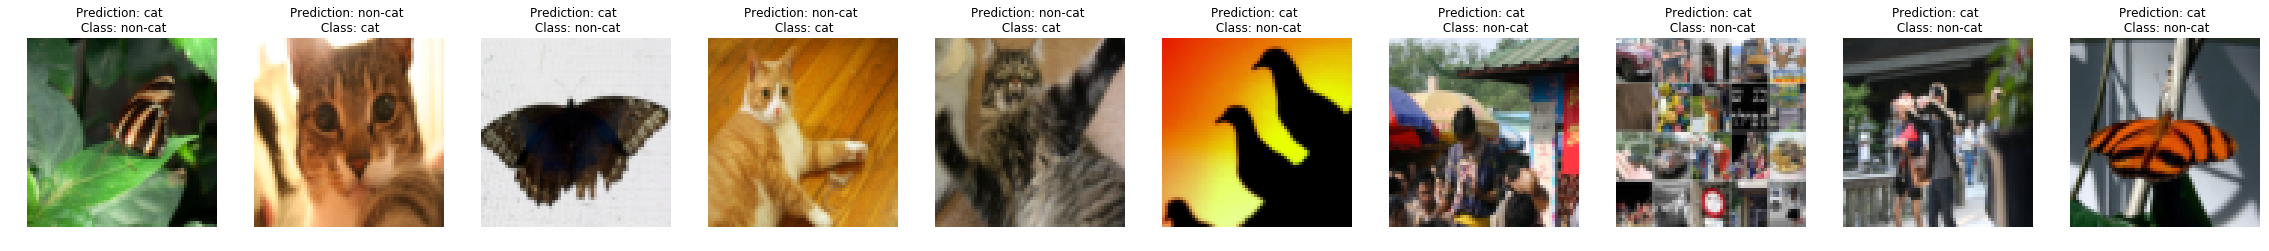

In [20]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

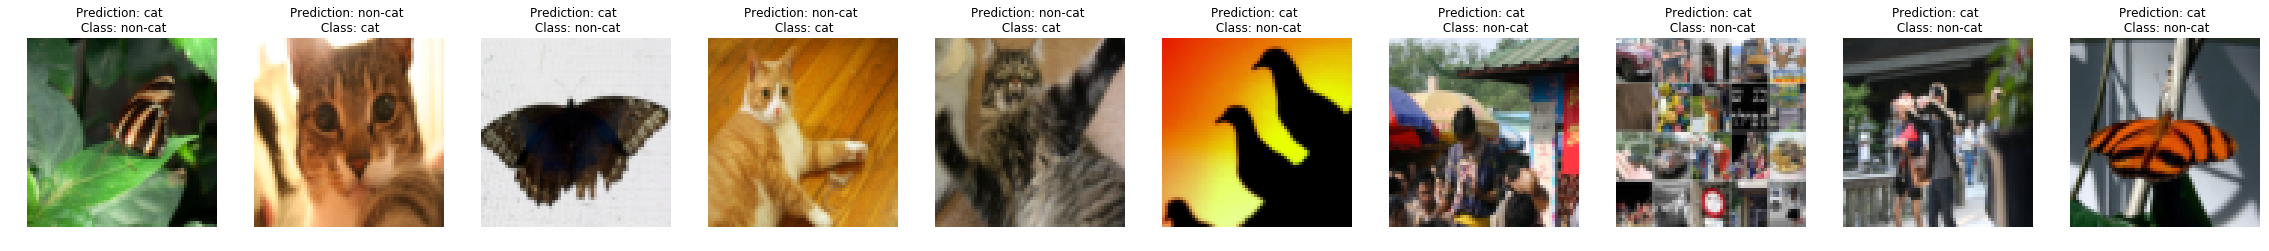

In [20]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

## 7) Test with your own image (optional/ungraded exercise) ##

Congratulations on finishing this assignment. You can use your own image and see the output of your model. To do that:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Change your image's name in the following code
    4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

In [10]:
## START CODE HERE ##
my_image = "my_image.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "images/" + my_image
image = ndimage.imread(fname, flatten=False)
print(type(image))
print(image.shape)
image = np.array(image)
print(type(image))
print(image.shape)
my_imagec = scipy.misc.imresize(image, size=(num_px,num_px))
print(my_imagec.shape)
# print(my_image)
my_image = my_imagec.reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.subplot(1,2,1)
plt.imshow(image)
print("cropped image:")
plt.subplot(1,3,2)
plt.imshow(my_imagec)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

<class 'numpy.ndarray'>
(681, 1024, 3)
<class 'numpy.ndarray'>
(681, 1024, 3)
(64, 64, 3)


NameError: name 'parameters' is not defined

**References**:

- for auto-reloading external module: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

## 3 - Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

You will build two different models:
- A 2-layer neural network
- An L-layer deep neural network

You will then compare the performance of these models, and also try out different values for $L$. 

Let's look at the two architectures.

### 3.1 - 2-layer neural network

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: 2-layer neural network. <br> The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You then repeat the same process.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias). 
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.

### 3.2 - L-layer deep neural network

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

### 3.3 - General methodology

As usual you will follow the Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

Let's now implement those two models!